In [1]:
import matplotlib.pyplot as plt
import numpy as np
import walras
from importlib import reload
reload(walras)
from walras import ConstantProductAMM, LimitOrder
from functools import reduce
import math
from scipy.optimize import minimize
from collections import defaultdict

Here's a scenario with just 2 tokens(A and B), a stack of limit orders, and 1 ConstantProduct AMM.

In [2]:
# This is a one-sided Limit Order that works by selling 100 of token B at a price of 1.01 for Token A. 
lim1 = LimitOrder(100, 1.01, 'A', 'B')
lim2 = LimitOrder(100, 1.02, 'A', 'B')
lim3 = LimitOrder(100, 1.03, 'A', 'B')
# This is a one-sided Limit Order that works by selling 100 of token A at a price of 1.01 for Token B. There is a subtle difference in the order of the tokens we're asking for.
lim4 = LimitOrder(100, 1.01, 'B', 'A')
lim5 = LimitOrder(100, 1.02, 'B', 'A')
lim6 = LimitOrder(100, 1.03, 'B', 'A')
# limit_orders = [lim1, lim2, lim3, lim4, lim5, lim6]

# This is the list of Limit Orders in the order they will be executed in the AMM.
limit_orders = [lim1, lim2, lim3, lim4, lim5, lim6]

# TODO: Figure out what Andrew meant by this
# price_vector = 1.0

Here's the AMM, configured with initial pool reserve amounts for tokens A and B. Token A has a reserve of 1000. Token B has a reserve of 1100.

In [1]:
# Amount of tokens in pool for token A
poolA=1000
# Amount of tokens in pool for token B
poolB=1100

# Constant product AMM configured for tokens A and B with reserve amounts.
pool1 = ConstantProductAMM(poolA, poolB, 'A', 'B')

NameError: name 'ConstantProductAMM' is not defined

We can represent the scenario just by the list of supply functions. The supply function describes the result of a trade.

In [4]:
supply_functions = [lim.supply for lim in limit_orders] + [pool1.supply]

Sum a list of supply functions (Better to make a class?)

In [5]:
def sum_supply(supply_funcs):
    def _supply(price_dict):
        # This defaultdict returns 0 as the default value of a key NOT IN the dictionary already. 
        supply_dict = defaultdict(lambda: 0)
        # for each supply function in the list of supply_funcs
        for supply_func in supply_funcs:
            # apply the supply function to the price_dict and add the resulting trade to the supply dictionary
            for key, value in supply_func(price_dict).items():
                supply_dict[key] += value
        # returns the supply dictionary
        return supply_dict
    # returns the function that 
    return _supply

In [6]:
def net_demand(supply_functions, price_vector):
    # Initialize a dictionary to hold the net demand for each token
    net_demand = defaultdict(lambda: 0)

    # For each supply function, calculate the supply and add it to the net demand
    for supply_func in supply_functions:
        supply = supply_func(price_vector)
        for token, amount in supply.items():
            # print('token', token, price_vector[token])
            net_demand[token] += amount

    # The net demand can be negative (net supply) or positive (net demand)
    # print('net_demand', net_demand)
    return net_demand

In [7]:
def find_market_clearing_price_scipy(supply_functions, initial_price_vector):
    # The error vector is the L2 sum of net demand of each asset...
    #    should it matter if this is scaled by relative price? how to normalize?
    def error_vector(price_vector):
        price_dict = {token: price for token, price in zip(initial_price_vector.keys(), price_vector)}
        net_demands = net_demand(supply_functions, price_dict)
        return sum([v*v for v in net_demands.values()])

    # Convert initial price vector to a list for fsolve
    initial_prices = list(initial_price_vector.values())

    # Use scipy to find the price vector that makes net demand zero
    clearing_prices = minimize(error_vector,
                               x0=initial_prices,
                               bounds=2*[(1e-15,None)]) # Prices must be positive
    print('clearing prices:', clearing_prices)
    print('error_vec initial:', error_vector(initial_prices))
    print('error_vec with solution', error_vector(clearing_prices.x))

    # Convert back to a dictionary
    return {token: price for token, price in zip(initial_price_vector.keys(), clearing_prices.x)}

In [8]:
initial_price_vector = {'A': 1.0, 'B': 1.0}
market_clearing_price = find_market_clearing_price_scipy(supply_functions, initial_price_vector)
# market_clearing_price = initial_price_vector
rel_price = market_clearing_price['B'] / market_clearing_price['A']
print("Market Clearing Price:", rel_price)
print('Residual net demand:', net_demand(supply_functions, market_clearing_price))

clearing prices:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.001552849441198e-08
        x: [ 1.010e+00  1.000e+00]
      nit: 4
      jac: [ 2.046e+04  1.959e+04]
     nfev: 144
     njev: 48
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
error_vec initial: 4764.607319393818
error_vec with solution 5.001552849441198e-08
Market Clearing Price: 0.990055862052047
Residual net demand: defaultdict(<function net_demand.<locals>.<lambda> at 0x7f1e69cf49d0>, {'A': 0.00015734626526864304, 'B': -0.0001589266538388756})


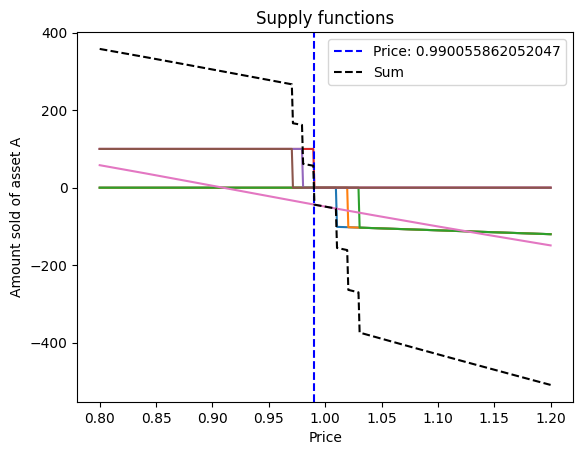

In [9]:
def plot_supply(supply_funcs, my_price=None, title=None):
    plt.figure(3)
    plt.clf()
    A = 'A'
    B = 'B'
    
    # Relative price
    p_values = np.linspace(0.8,1.2,400)
    supply_values = np.zeros((len(supply_funcs),len(p_values)))
    tokens = ['A','B']
    def price_vector(rel_price):
        return {A: 1.0, B: rel_price}
    def eval_supply(supply_func, rel_price):
        
        As = [supply_func(price_vector(p))['A'] for p in rel_price]
        Bs = [supply_func(price_vector(p))['B'] for p in rel_price]
        for a,b,p in zip(As,Bs,rel_price):
            assert np.isclose(a + b*p, 0)
        return As
    for f in supply_funcs:
        ys = eval_supply(f, p_values)
        if 'AMM' in str(type(f)):
            label = 'AMM'
        elif 'LimitOrder' in str(type(f)):
            label = 'Limit Order'
        else: label = None
        plt.plot(p_values, ys, label=label)

    # Price vector as a vertical line
    plt.axvline(x=my_price, color='blue', linestyle='--', label=f'Price: {rel_price}')
    summed = sum_supply(supply_funcs)
    ys = eval_supply(summed, p_values)
    plt.plot(p_values, ys, 'k--', label='Sum')
    plt.ylabel('Amount sold of asset A')
    plt.xlabel('Price')
    plt.title(title)
    plt.legend()
    plt.draw()
    
plot_supply([x.supply for x in [lim1,lim2,lim3,lim4,lim5,lim6,pool1]],
            rel_price, 'Supply functions')

#<br>
Illustrations<br>
#


<br>
These are illustrations of how the individual components, namely limit <br>
order books and constant product AMMs respond to the proposed clearing price<br>


In [10]:
def plot_depth_chart(limit_orders, rel_price, A='A',B='B'):
    for order in limit_orders:
        assert order.A in (A,B)
        assert order.B in (A,B)
        assert order.A != order.B
    
    # Sort buy orders (buying B with A) and sell orders (selling B for A) based on price
    buy_orders = sorted([order for order in limit_orders if order.A == B], key=lambda x: x.price())
    sell_orders = sorted([order for order in limit_orders if order.A == A], key=lambda x: x.price())

    # Cumulative amounts for buy and sell orders
    cumulative_buy_amount = [0]
    buy_prices = []
    for order in buy_orders:
        amtB = order.poolB*order.price()
        price = 1./order.price()
        cumulative_buy_amount.append(cumulative_buy_amount[-1] + amtB)
        cumulative_buy_amount.append(cumulative_buy_amount[-1])
        buy_prices.append(price)
        buy_prices.append(price)
    cumulative_sell_amount = [0]
    sell_prices = []
    for order in sell_orders:
        amtB = order.poolB
        cumulative_sell_amount.append(cumulative_sell_amount[-1] + amtB)
        cumulative_sell_amount.append(cumulative_sell_amount[-1])
        sell_prices.append(order.price())
        sell_prices.append(order.price())
    cumulative_sell_amount.pop()
    cumulative_buy_amount.pop()

    # Asset nets
    all_prices = []
    asset_nets = []
    for price in sorted(buy_prices + sell_prices):
        all_prices.append(price)
        net = 0
        # Just need the amount of B bought/sold
        for order in buy_orders + sell_orders:
            d = order.supply(dict(A=1.0,B=price))
            net += price * d[A]
        asset_nets.append(net)
    
    # Plotting
    plt.figure(1, figsize=(10, 6))
    plt.clf()

    # Plot for buy orders
    plt.fill_between(buy_prices, 0, cumulative_buy_amount, color='green', alpha=0.5, label='Buys')
    
    # Plot for sell orders
    plt.fill_between(sell_prices, 0, cumulative_sell_amount, color='red', alpha=0.5, label='Sells')

    # Price vector as a vertical line
    plt.axvline(x=rel_price, color='blue', linestyle='--', label=f'Price: {rel_price}')

    # Plot supply function end points
    plt.plot(all_prices, asset_nets, linestyle='--',color='black', label='supply(p)')
    plt.xlabel('Price')
    plt.ylabel('Cumulative Amount')
    plt.title('Depth Chart of Limit Orders')
    plt.legend()
    plt.grid(True)
    plt.draw()

In [11]:
def plot_amm(poolA, poolB, rel_price):

    # Trade vector from the supply function at this price
    pool = ConstantProductAMM(poolA, poolB,'A','B')
    print('ok')
    trade_vec = pool.supply(dict(A=1.,B=rel_price))
    if trade_vec['A'] > 0:
        # The virtual agent sold us some amtA. But we overpaid in trade_vec B.
        # We need to solve backward by price.
        # print('case 1', trade_vec)
        amtB = -trade_vec['B']
        trade_amtA = -amtB*poolA/(amtB + poolB)
    else:
        # print('case 2')
        trade_amtA = -trade_vec['A']
    trade_amtB = -pool.trade(trade_amtA)
    # print('trade_amtA:', trade_amtA)
    # print('trade_amtB:', trade_amtB)
    end_point_A = poolA + trade_amtA
    end_point_B = poolB + trade_amtB
    assert np.isclose((end_point_A)/(end_point_B), rel_price)

    # Generate points for the constant product curve
    # Avoid zero to prevent division by zero
    a_values = np.linspace(0.98 * min(poolA,end_point_A), 1.02*max(poolA,end_point_A), 200)
    b_values = poolA * poolB / a_values

    # Tangent goes through ending point
    #print('rel_price', rel_price)
    #print('end point:', end_point_A / end_point_B)
    tangent_line = end_point_B + (a_values - end_point_A) * -1./rel_price

    # Plotting
    plt.figure(2, figsize=(8, 6))
    plt.clf()
    plt.plot(a_values, b_values, label='Constant Product Curve')
    plt.plot([poolA, end_point_A], [poolB, end_point_B], 'ro-',
             label='Trade vector to reach price')
    plt.plot(a_values, tangent_line, 'b--', label=f'Price {rel_price}')
    plt.xlabel('Amount of Token A')
    plt.ylabel('Amount of Token B')
    plt.title('Automated Market Maker (AMM) Behavior')
    plt.legend()
    plt.grid(True)
    plt.draw()

ok


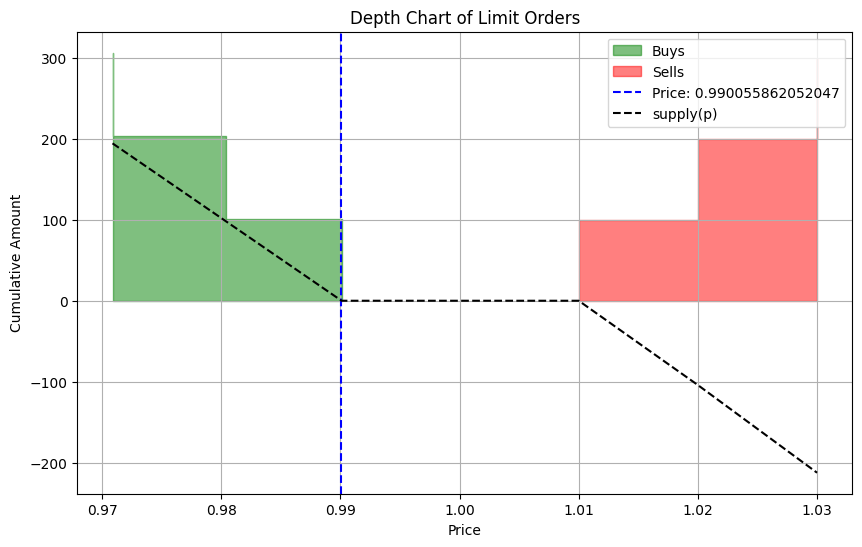

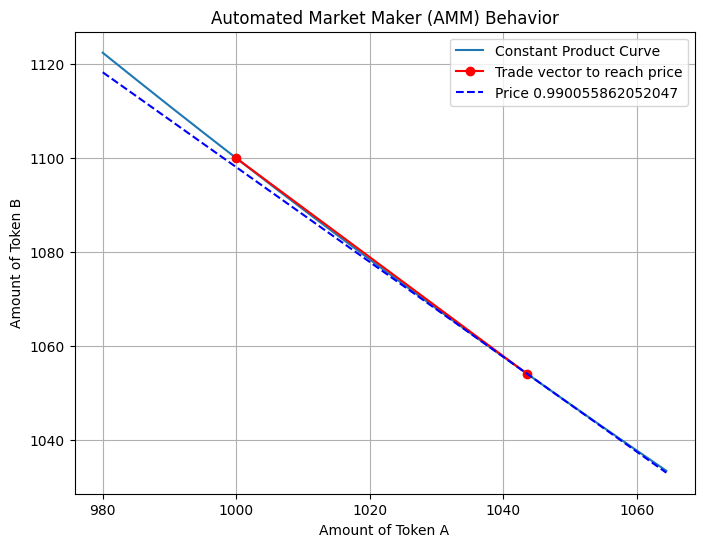

In [12]:
plot_depth_chart(limit_orders, rel_price)
plot_amm(poolA=poolA, poolB=poolB, rel_price=rel_price)

In [13]:
plt.show()